# Data Mining Project - Bank

## Project Developed by:
- *Duarte Sardão*
- *Gabriel Ferreira*
- *Miguel Lopes*
- *Sérgio Estêvão*

## Table of Contents
1. Business Understanding

## Business Understanding

The dataset is composed of a series of information that describe the activity of a Czech bank during the 90s. This includes account, client, credit cards, transaction and loan information as well as information regarding the districts where the bank's clients reside.

With this information we are expected to create a predictive model that allows the end user to determine whether or not a client is suitable to get a loan. 

In this business context, a client is granted a loan if the model predicts that the client will be able to pay it in full.

The business goals are the following: 
- Minimize the number of defective loans (loans that don't get paid in full)
- Maximize the number of loans paid in full

The data mining goals are: ver outras apresentações

In [ ]:
import pandas as pd
from datetime import datetime

We start by loading the data into dataframes and removing information that has no relation to loans, as that data is irrelevant to the problem being targeted in this project.

In [ ]:
loans = pd.read_csv("./data/loan_dev.csv", sep=";")
transactions = pd.read_csv("./data/trans_dev.csv", sep=";")
accounts = pd.read_csv("./data/account.csv", sep=";")
cards = pd.read_csv("./data/card_dev.csv", sep=";")
clients = pd.read_csv("./data/client.csv", sep=";")
dispositions = pd.read_csv("./data/disp.csv", sep=";")
districts = pd.read_csv("./data/district.csv", na_values=['?'], sep=";")

print("transactions: ", len(transactions))
print("accounts: ", len(accounts))
print("dispositions: ", len(dispositions))
print("clients: ", len(clients))
print("cards: ", len(cards))
print("districts: ", len(districts))
print("loans: ", len(loans))


#Clean up information not associated with loans

account_ids = loans['account_id'].unique()

transactions.query("account_id in @account_ids", inplace=True)
accounts.query("account_id in @account_ids", inplace=True)
dispositions.query("account_id in @account_ids", inplace=True)

#save how many clients are associated to an account, might matter
accounts['num_clients'] = accounts.apply(lambda row: dispositions['account_id'].value_counts()[row.account_id], axis=1)

#but drop their info
dispositions.query("type == 'OWNER'", inplace=True)

client_ids = dispositions['client_id'].unique()
disp_ids = dispositions['disp_id'].unique()
district_ids = accounts['district_id'].unique()

#rename cuz of ending spaces
districts = districts.rename(columns={"code ": "code",
                   "name ": "name"})

clients.query("client_id in @client_ids", inplace=True)
cards.query("disp_id in @disp_ids", inplace=True)
districts.query("code in @district_ids", inplace=True)


print("==== After clean-up ====")
print("transactions: ", len(transactions))
print("accounts: ", len(accounts))
print("dispositions: ", len(dispositions))
print("clients: ", len(clients))
print("cards: ", len(cards))
print("districts: ", len(districts))

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


transactions:  396685
accounts:  4500
dispositions:  5369
clients:  5369
cards:  177
districts:  77
loans:  328
==== After clean-up ====
transactions:  24494
accounts:  328
dispositions:  328
clients:  328
cards:  11
districts:  73


In [ ]:
dispaccs = pd.merge(dispositions, accounts, on="account_id")
dispaccs.drop(columns="type", inplace=True)
dispaccs = dispaccs.rename(columns={"date": "creation", "district_id": "branch_district_id"})
clients = pd.merge(dispaccs, clients, on="client_id")
clients = clients.rename(columns={"district_id": "client_district_id"})
clients.head()

,disp_id,client_id,account_id,branch_district_id,frequency,creation,num_clients,birth_number,client_district_id
0,2,2,2,1,monthly issuance,930226,2,450204,1
1,25,25,19,21,monthly issuance,950407,1,395423,21
2,78,78,67,16,monthly issuance,941019,1,445613,16
3,158,158,132,40,issuance after transaction,960511,2,455703,40
4,210,210,173,66,monthly issuance,931126,2,391130,66


In [ ]:
from datetime import datetime
#transform birth number into birthdate and sex
birth_number = clients["birth_number"]
clients["sex"] = birth_number.map(lambda nr: "Male" if nr % 10000 < 5000 else "Female").astype('category')
clients["birthdate"] = birth_number.map(lambda nr: str(nr) if nr % 10000 < 5000 else str(nr-5000))
clients["birthdate"] = pd.to_datetime("19"+clients["birthdate"], format='%Y%m%d')
clients.drop(columns="birth_number", inplace=True)
clients.head()


,disp_id,client_id,account_id,branch_district_id,frequency,creation,num_clients,client_district_id,sex,birthdate
0,2,2,2,1,monthly issuance,930226,2,1,Male,1945-02-04
1,25,25,19,21,monthly issuance,950407,1,21,Female,1939-04-23
2,78,78,67,16,monthly issuance,941019,1,16,Female,1944-06-13
3,158,158,132,40,issuance after transaction,960511,2,40,Female,1945-07-03
4,210,210,173,66,monthly issuance,931126,2,66,Male,1939-11-30


In [ ]:
#other date treatment (yymmdd string to datetime format)
cards["issued"] = cards["issued"].map(lambda nr: str(nr))
cards["issued"] = pd.to_datetime("19"+cards["issued"], format='%Y%m%d')

transactions["date"] = transactions["date"].map(lambda nr: str(nr))
transactions["date"] = pd.to_datetime("19"+transactions["date"], format='%Y%m%d')

loans["date"] = loans["date"].map(lambda nr: str(nr))
loans["date"] = pd.to_datetime("19"+loans["date"], format='%Y%m%d')

clients["creation"] = clients["creation"].map(lambda nr: str(nr))
clients["creation"] = pd.to_datetime("19"+clients["creation"], format='%Y%m%d')


282
46


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


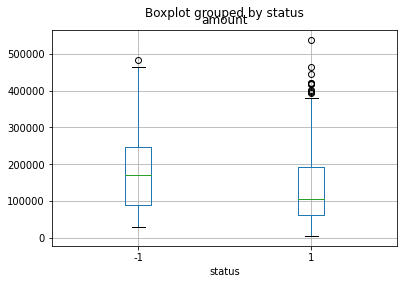

In [ ]:
# Amount of successful loans
print(len(loans[loans['status']==1]))

# Amount of unsuccessful loans
print(len(loans[loans['status']==-1]))

# Loan ammount by status
loans.boxplot(column="amount",by="status")

In [ ]:
#calc crimerates rather than whole values
districts['crimerate95'] = districts.apply(lambda row: row["no. of commited crimes '95 "] / row["no. of inhabitants"], axis=1)
districts['crimerate96'] = districts.apply(lambda row: row["no. of commited crimes '96 "] / row["no. of inhabitants"], axis=1)
#calculate with growth rate from 95-96
districts['crimegrowth'] = districts.apply(lambda row: row["crimerate96"] / row["crimerate95"], axis=1)
districts['unempgrowth'] = districts.apply(lambda row: row["unemploymant rate '96 "] / row["unemploymant rate '95 "], axis=1)
 
#drops columns now calculated with relative vals and growth
districts.drop(columns="crimerate95", inplace=True)
districts.drop(columns="no. of commited crimes '95 ", inplace=True)
districts.drop(columns="no. of commited crimes '96 ", inplace=True)
districts.drop(columns="unemploymant rate '95 ", inplace=True)
 
#clean up names for better experience
districts = districts.rename(columns={"no. of inhabitants": "pop",
                   "no. of municipalities with inhabitants < 499 ": "munip<499",
                   "no. of municipalities with inhabitants 500-1999": "munip500-1999",
                   "no. of municipalities with inhabitants 2000-9999 ": "munip2000-9999",
                   "no. of municipalities with inhabitants >10000 ": "munip>10000",
                   "no. of municipalities with inhabitants >10000 ": "munip>10000",
                   "no. of cities ": "cities",
                   "ratio of urban inhabitants ": "urbanization",
                   "average salary ": "avg-salary",
                   "unemploymant rate '96 ": "unemployment96",
                   "no. of enterpreneurs per 1000 inhabitants ": "entrepreneurs/1000"
                  })
 
#handle missing vals remaining in crimegrowth, unempgrowth with K-nearest neighbour
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
df_knn = districts.copy()
df_knn.drop(columns=["code", "name", "region"], inplace=True)
#scale values from 0-1 for KNN
scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)
#target values scaled, reset
df_knn['crimegrowth'] = districts['crimegrowth']
df_knn['unempgrowth'] = districts['unempgrowth']
#impute knn
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)
 
districts.fillna(df_knn_imputed, inplace=True)


In [ ]:
transaction_index = {} #['account_id] = {RecentBalance, MonthBalance, 6MonthBalance, 12MonthBalance}

transactions_bydate = transactions.sort_values(by="date", ascending=False)




for index, transaction in transactions_bydate.iterrows():
    account_id = transaction["account_id"]
    if account_id not in transaction_index.keys():
        transaction_index[account_id] = {}
        transaction_index[account_id]["RecentBalance"] = transaction

    else:
    
        delta = transaction_index[account_id]["RecentBalance"]["date"] - transaction["date"]
        #print(type(delta))

        if "MonthBalance" not in transaction_index[account_id].keys():
            if delta.days > 30:
                transaction_index[account_id]["MonthBalance"] = transaction["balance"]
        elif "6MonthBalance" not in transaction_index[account_id].keys():
            if delta.days > 180:
                transaction_index[account_id]["6MonthBalance"] = transaction["balance"]
        elif "12MonthBalance" not in transaction_index[account_id].keys():
            if delta.days > 365: 
                transaction_index[account_id]["12MonthBalance"] = transaction["balance"]
 


for index in transaction_index.keys():
    transaction_index[index]["RecentBalance"] = transaction_index[index]["RecentBalance"]["balance"]


In [ ]:

#merge the balance dataset (transaction_index) with the accounts dataset to get the final accounts dataset with balance information
for account_id in transaction_index.keys():
    transaction_index[account_id]["account_id"] = int(account_id)

transaction_index_df = pd.DataFrame(transaction_index)

transaction_index_df = transaction_index_df.transpose()




accounts_with_balances = pd.merge(accounts, transaction_index_df, on="account_id", how="outer")
accounts_with_balances

,account_id,district_id,frequency,date,num_clients,RecentBalance,MonthBalance,6MonthBalance,12MonthBalance
0,5270,44,monthly issuance,930113,1,103745.7,95837.6,99164.6,NaN
1,11265,15,monthly issuance,930114,1,21029.0,22777.4,26079.8,NaN
2,10364,55,monthly issuance,930117,2,49083.3,46512.7,48442.4,NaN
3,3834,54,monthly issuance,930119,2,28531.7,26930.8,26367.4,22494.0
4,9307,68,monthly issuance,930124,1,39204.7,75488.7,24366.2,14177.4
...,...,...,...,...,...,...,...,...,...
323,4585,27,monthly issuance,960608,2,44749.0,21989.3,NaN,NaN
324,9510,1,monthly issuance,960609,2,53707.9,60236.6,NaN,NaN
325,7926,69,weekly issuance,960609,1,63952.9,67449.9,NaN,NaN
326,4447,62,monthly issuance,960616,2,27799.1,35314.7,NaN,NaN
